In [1]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt

# Handle table like and matrices
import pandas as pd
import numpy as np

# Modeling Helper
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

import test_stationarity 

# Configure visualization
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 10,8

def date_parser(date):
    return pd.datetime.strptime(date, '%Y-%m')

# 读取数据，pd.read_csv默认生成DataFrame对象，需将其转换成Series对象
data = pd.read_csv('AirPassengers.csv', header=0, parse_dates=['Month'], date_parser=date_parser, index_col=['Month'])
data.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
ts = data['Passengers']  # 生成pd.Series对象
# 查看数据格式
ts.head()
ts.head().index 

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01'],
              dtype='datetime64[ns]', name=u'Month', freq=None)

In [3]:
test_stationarity.testStationarity(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64

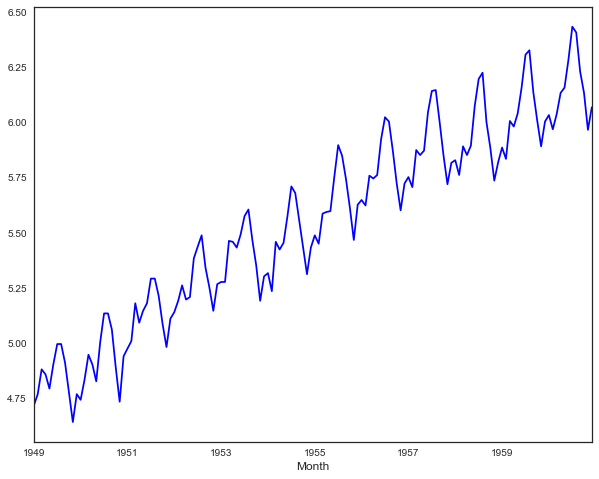

In [4]:
ts_log = np.log(ts)
test_stationarity.draw_ts(ts_log)

test_stationarity.py:14: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=12,min_periods=0,adjust=True).mean()
  rol_weighted_mean = pd.ewma(timeSeries, span=size)


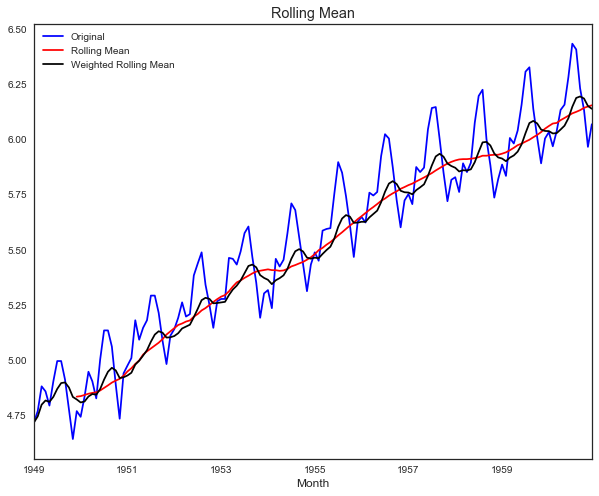

In [5]:
test_stationarity.draw_trend(ts_log, 12)

In [6]:
diff_12 = ts_log.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
test_stationarity.testStationarity(diff_12_1)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (5%)             -2.886363
Critical Value (1%)             -3.487022
Critical Value (10%)            -2.580009
dtype: float64

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model="additive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

C:\Anaconda2\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


In [8]:
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
test_stationarity.testStationarity(ts_diff_1)

Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64

In [9]:
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)

In [10]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_2, order=(1, 1)) 
result_arma = model.fit( disp=-1, method='css')

C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

C:\Anaconda2\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


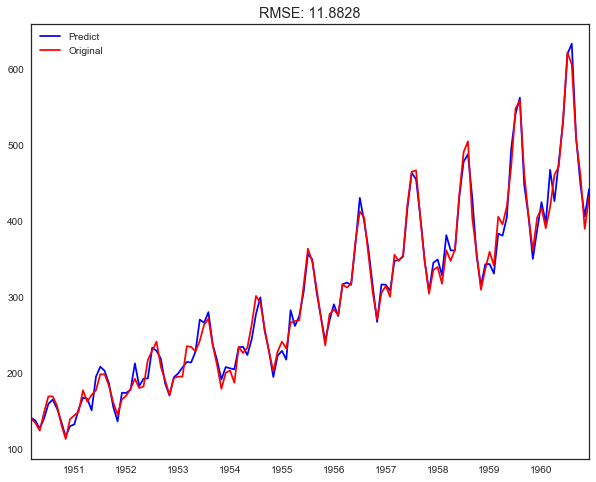

In [12]:
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

### 封装

In [5]:
# 差分操作
def diff_ts(ts, d):
    global shift_ts_list
    #  动态预测第二日的值时所需要的差分序列
    global last_data_shift_list
    shift_ts_list = []
    last_data_shift_list = []
    tmp_ts = ts
    for i in d:
        last_data_shift_list.append(tmp_ts[-i])
        print last_data_shift_list
        shift_ts = tmp_ts.shift(i)
        shift_ts_list.append(shift_ts)
        tmp_ts = tmp_ts - shift_ts
    tmp_ts.dropna(inplace=True)
    return tmp_ts

# 还原操作
def predict_diff_recover(predict_value, d):
    if isinstance(predict_value, float):
        tmp_data = predict_value
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    elif isinstance(predict_value, np.ndarray):
        tmp_data = predict_value[0]
        for i in range(len(d)):
            tmp_data = tmp_data + last_data_shift_list[-i-1]
    else:
        tmp_data = predict_value
        for i in range(len(d)):
            try:
                tmp_data = tmp_data.add(shift_ts_list[-i-1])
            except:
                raise ValueError('What you input is not pd.Series type!')
        tmp_data.dropna(inplace=True)
    return tmp_data

# -*-coding:utf-8-*-
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARMA
import sys
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import matplotlib.pyplot as plt

class arima_model:

    def __init__(self, ts, maxLag=9):
        self.data_ts = ts
        self.resid_ts = None
        self.predict_ts = None
        self.maxLag = maxLag
        self.p = maxLag
        self.q = maxLag
        self.properModel = None
        self.bic = sys.maxint

    # 计算最优ARIMA模型，将相关结果赋给相应属性
    def get_proper_model(self):
        self._proper_model()
        self.predict_ts = deepcopy(self.properModel.predict())
        self.resid_ts = deepcopy(self.properModel.resid)

    # 对于给定范围内的p,q计算拟合得最好的arima模型，这里是对差分好的数据进行拟合，故差分恒为0
    def _proper_model(self):
        for p in np.arange(self.maxLag):
            for q in np.arange(self.maxLag):
                # print p,q,self.bic
                model = ARMA(self.data_ts, order=(p, q))
                try:
                    results_ARMA = model.fit(disp=-1, method='css')
                except:
                    continue
                bic = results_ARMA.bic
                # print 'bic:',bic,'self.bic:',self.bic
                if bic < self.bic:
                    self.p = p
                    self.q = q
                    self.properModel = results_ARMA
                    self.bic = bic
                    self.resid_ts = deepcopy(self.properModel.resid)
                    self.predict_ts = self.properModel.predict()

    # 参数确定模型
    def certain_model(self, p, q):
            model = ARMA(self.data_ts, order=(p, q))
            try:
                self.properModel = model.fit( disp=-1, method='css')
                self.p = p
                self.q = q
                self.bic = self.properModel.bic
                self.predict_ts = self.properModel.predict()
                self.resid_ts = deepcopy(self.properModel.resid)
            except:
                print 'You can not fit the model with this parameter p,q, ' \
                      'please use the get_proper_model method to get the best model'

    # 预测第二日的值
    def forecast_next_day_value(self, type='day'):
        # 我修改了statsmodels包中arima_model的源代码，添加了constant属性，需要先运行forecast方法，为constant赋值
        self.properModel.forecast()
        if self.data_ts.index[-1] != self.resid_ts.index[-1]:
            raise ValueError('''The index is different in data_ts and resid_ts, please add new data to data_ts.
            If you just want to forecast the next day data without add the real next day data to data_ts,
            please run the predict method which arima_model included itself''')
        if not self.properModel:
            raise ValueError('The arima model have not computed, please run the proper_model method before')
        para = self.properModel.params

        # print self.properModel.params
        if self.p == 0:   # It will get all the value series with setting self.data_ts[-self.p:] when p is zero
            ma_value = self.resid_ts[-self.q:]
            values = ma_value.reindex(index=ma_value.index[::-1])
        elif self.q == 0:
            ar_value = self.data_ts[-self.p:]
            values = ar_value.reindex(index=ar_value.index[::-1])
        else:
            ar_value = self.data_ts[-self.p:]
            ar_value = ar_value.reindex(index=ar_value.index[::-1])
            ma_value = self.resid_ts[-self.q:]
            ma_value = ma_value.reindex(index=ma_value.index[::-1])
            values = ar_value.append(ma_value)

        predict_value = np.dot(para[1:], values) + self.properModel.constant[0]
        self._add_new_data(self.predict_ts, predict_value, type)
        return predict_value

    # 动态添加数据函数，针对索引是月份和日分别进行处理
    def _add_new_data(self, ts, dat, type='day'):
        if type == 'day':
            new_index = ts.index[-1] + relativedelta(days=1)
        elif type == 'month':
            new_index = ts.index[-1] + relativedelta(months=1)
        ts[new_index] = dat

    def add_today_data(self, dat, type='day'):
        self._add_new_data(self.data_ts, dat, type)
        if self.data_ts.index[-1] != self.predict_ts.index[-1]:
            raise ValueError('You must use the forecast_next_day_value method forecast the value of today before')
        self._add_new_data(self.resid_ts, self.data_ts[-1] - self.predict_ts[-1], type)

In [3]:
diffed_ts = diff_ts(ts_log, d=[12, 1])
model = arima_model(diffed_ts)
model.certain_model(1, 1)
predict_ts = model.properModel.predict()
diff_recover_ts = predict_diff_recover(predict_ts, d=[12, 1])
log_recover = np.exp(diff_recover_ts)
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

NameError: name 'ts_log' is not defined

## train_new

In [67]:
train_new = pd.read_csv('train_new_total.csv')
train_12 = train_new[train_new['Class'] == 12][['SaleDate','saleCount']]
train_12

,SaleDate,saleCount
21600,2015-01-01,103
21601,2015-01-02,99
21602,2015-01-03,80
21603,2015-01-04,107
21604,2015-01-05,161
21605,2015-01-06,146
21606,2015-01-07,144
21607,2015-01-08,129
21608,2015-01-09,104
21609,2015-01-10,97


[4.9199809258281251]
[4.9199809258281251, -0.48145101508608601]


C:\Anaconda2\lib\site-packages\statsmodels\base\data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


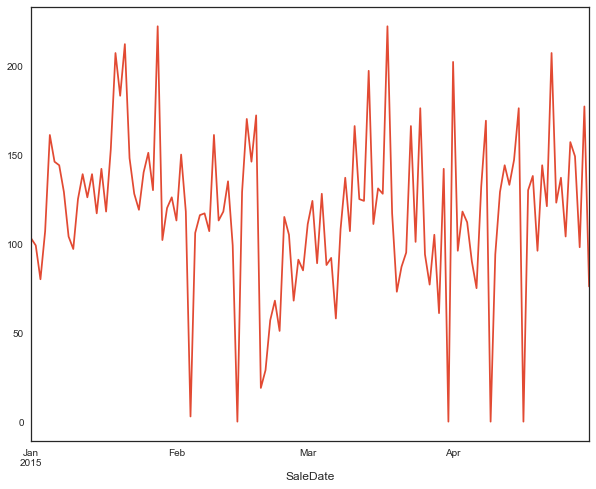

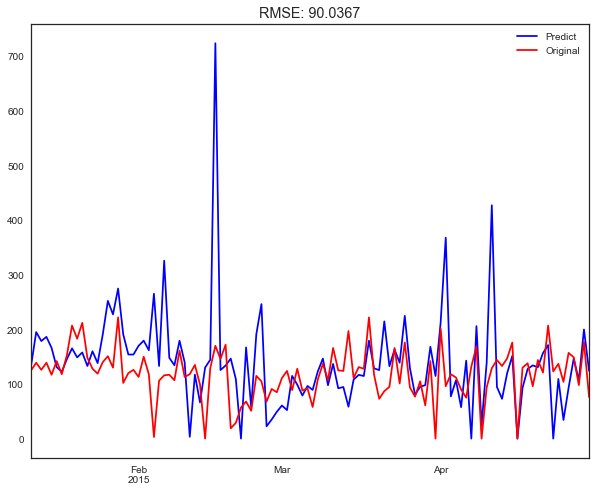

In [7]:
data = train_12.copy()
data.to_csv('train_12.csv',index=False)
data = pd.read_csv('train_12.csv',index_col=['SaleDate'])
data['saleCount'][data['saleCount'] == 0] = 0.1
data.index = pd.to_datetime(data.index)
ts = data['saleCount']  # 生成pd.Series对象
ts_log = np.log(ts)
ts_log.head().index
ts.plot()

d = [7,1]
diffed_ts = diff_ts(ts_log, d)
model = arima_model(diffed_ts)
model.certain_model(2, 1)
predict_ts = model.properModel.predict()
diff_recover_ts = predict_diff_recover(predict_ts, d)
log_recover = np.exp(diff_recover_ts)
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

In [153]:
def proper_model(data_ts, maxLag):
    init_bic = sys.maxint
    init_p = 0
    init_q = 0
    init_properModel = None
    for p in np.arange(maxLag):
        for q in np.arange(maxLag):
            model = ARMA(data_ts, order=(p, q))
            try:
                results_ARMA = model.fit(disp=-1, method='css')
            except:
                continue
            bic = results_ARMA.bic
            if bic < init_bic:
                init_p = p
                init_q = q
                init_properModel = results_ARMA
                init_bic = bic
    return init_bic, init_p, init_q, init_properModel

In [ ]:
proper_model(ts_log,5)

C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-pac

C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-pac

bic: 77.7170390707 p: 0 q: 7
[ 0.12721383]
forcast 0.127213828303


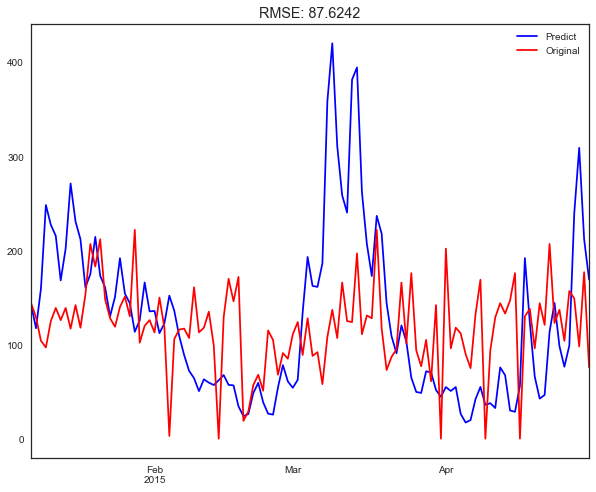

In [50]:
# -*-coding:utf-8-*-
import pandas as pd
import numpy as np
from arima_model import ARMA
import sys
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import matplotlib.pyplot as plt

class arima_model:

    def __init__(self, ts, maxLag=9):
        self.data_ts = ts
        self.resid_ts = None
        self.predict_ts = None
        self.maxLag = maxLag
        self.p = maxLag
        self.q = maxLag
        self.properModel = None
        self.bic = sys.maxint

    # 计算最优ARIMA模型，将相关结果赋给相应属性
    def get_proper_model(self):
        self._proper_model()
        self.predict_ts = deepcopy(self.properModel.predict())
        self.resid_ts = deepcopy(self.properModel.resid)

    # 对于给定范围内的p,q计算拟合得最好的arima模型，这里是对差分好的数据进行拟合，故差分恒为0
    def _proper_model(self):
        for p in np.arange(self.maxLag):
            for q in np.arange(self.maxLag):
                # print p,q,self.bic
                model = ARMA(self.data_ts, order=(p, q))
                try:
                    results_ARMA = model.fit(disp=-1, method='css')
                except:
                    continue
                bic = results_ARMA.bic
                # print 'bic:',bic,'self.bic:',self.bic
                if bic < self.bic:
                    self.p = p
                    self.q = q
                    self.properModel = results_ARMA
                    self.bic = bic
                    self.resid_ts = deepcopy(self.properModel.resid)
                    self.predict_ts = self.properModel.predict()

    # 参数确定模型
    def certain_model(self, p, q):
            model = ARMA(self.data_ts, order=(p, q))
            try:
                self.properModel = model.fit( disp=-1, method='css')
                self.p = p
                self.q = q
                self.bic = self.properModel.bic
                self.predict_ts = self.properModel.predict()
                self.resid_ts = deepcopy(self.properModel.resid)
            except:
                print 'You can not fit the model with this parameter p,q, ' \
                      'please use the get_proper_model method to get the best model'

    # 预测第二日的值
    def forecast_next_day_value(self, type='day'):
        # 我修改了statsmodels包中arima_model的源代码，添加了constant属性，需要先运行forecast方法，为constant赋值
        self.properModel.forecast()
        if self.data_ts.index[-1] != self.resid_ts.index[-1]:
            raise ValueError('''The index is different in data_ts and resid_ts, please add new data to data_ts.
            If you just want to forecast the next day data without add the real next day data to data_ts,
            please run the predict method which arima_model included itself''')
        if not self.properModel:
            raise ValueError('The arima model have not computed, please run the proper_model method before')
        para = self.properModel.params

        # print self.properModel.params
        if self.p == 0:   # It will get all the value series with setting self.data_ts[-self.p:] when p is zero
            ma_value = self.resid_ts[-self.q:]
            values = ma_value.reindex(index=ma_value.index[::-1])
        elif self.q == 0:
            ar_value = self.data_ts[-self.p:]
            values = ar_value.reindex(index=ar_value.index[::-1])
        else:
            ar_value = self.data_ts[-self.p:]
            ar_value = ar_value.reindex(index=ar_value.index[::-1])
            ma_value = self.resid_ts[-self.q:]
            ma_value = ma_value.reindex(index=ma_value.index[::-1])
            values = ar_value.append(ma_value)

        predict_value = np.dot(para[1:], values) + self.properModel.constant[0]
        self._add_new_data(self.predict_ts, predict_value, type)
        return predict_value

    # 动态添加数据函数，针对索引是月份和日分别进行处理
    def _add_new_data(self, ts, dat, type='day'):
        if type == 'day':
            new_index = ts.index[-1] + relativedelta(days=1)
        elif type == 'month':
            new_index = ts.index[-1] + relativedelta(months=1)
        ts[new_index] = dat

    def add_today_data(self, dat, type='day'):
        self._add_new_data(self.data_ts, dat, type)
        if self.data_ts.index[-1] != self.predict_ts.index[-1]:
            raise ValueError('You must use the forecast_next_day_value method forecast the value of today before')
        self._add_new_data(self.resid_ts, self.data_ts[-1] - self.predict_ts[-1], type)

if __name__ == '__main__':
    data = train_12.copy()
    data.to_csv('train_12.csv',index=False)
    data = pd.read_csv('train_12.csv',index_col=['SaleDate'])
    data['saleCount'][data['saleCount'] == 0] = 0.1
    data.index = pd.to_datetime(data.index)
    ts = data['saleCount']  # 生成pd.Series对象
    ts_log = np.log(ts)

    # 数据预处理
    step = 5
    ts_log = np.log(ts)
    rol_mean = ts_log.rolling(window=step).mean()
    rol_mean.dropna(inplace=True)
    ts_diff_1 = rol_mean.diff(1)
    ts_diff_1.dropna(inplace=True)
    ts_diff_2 = ts_diff_1.diff(1)
    ts_diff_2.dropna(inplace=True)

    # 模型拟合
    model = arima_model(ts_diff_2)
    #  这里使用模型参数自动识别
    model.get_proper_model()
    print 'bic:', model.bic, 'p:', model.p, 'q:', model.q
    print model.properModel.forecast()[0]
    print "forcast",model.forecast_next_day_value(type='day')

    # 预测结果还原
    predict_ts = model.properModel.predict()
    diff_shift_ts = ts_diff_1.shift(1)
    diff_recover_1 = predict_ts.add(diff_shift_ts)
    rol_shift_ts = rol_mean.shift(1)
    diff_recover = diff_recover_1.add(rol_shift_ts)
    rol_sum = ts_log.rolling(window=step-1).sum()
    rol_recover = diff_recover*step - rol_sum.shift(1)
    log_recover = np.exp(rol_recover)
    log_recover.dropna(inplace=True)

    # 预测结果作图
    ts = ts[log_recover.index]
    plt.figure(facecolor='white')
    log_recover.plot(color='blue', label='Predict')
    ts.plot(color='red', label='Original')
    plt.legend(loc='best')
    plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
    plt.show()
    
#     ts_train = ts_log[:'2015-03-31']
#     ts_test = ts_log['2015-04-01':]
    
#     d = [step,2]
#     diffed_ts = diff_ts(ts_train, d)
#     forecast_list = []

    
#     diffed_ts = diff_ts(ts_log, d=[12, 1])
#     model = arima_model(diffed_ts)
#     model.certain_model(1, 1)
#     predict_ts = model.properModel.predict()
#     diff_recover_ts = predict_diff_recover(predict_ts, d=[12, 1])
#     log_recover = np.exp(diff_recover_ts)
#     ts = ts[log_recover.index]  # 过滤没有预测的记录
#     plt.figure(facecolor='white')
#     log_recover.plot(color='blue', label='Predict')
#     ts.plot(color='red', label='Original')
#     plt.legend(loc='best')
#     plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
#     plt.show()

#     step = 10
# #     ts_log = np.log(ts)
#     rol_mean = ts_train.rolling(window=step).mean()
#     rol_mean.dropna(inplace=True)
#     ts_diff_1 = rol_mean.diff(1)
#     ts_diff_1.dropna(inplace=True)
#     ts_diff_2 = ts_diff_1.diff(1)
#     ts_diff_2.dropna(inplace=True)
    
#     for i, dta in enumerate(ts_test):
#         if i%7 == 0:
#             model = arima_model(ts_diff_2)
# #             model.certain_model(0, 1)
#             model.get_proper_model()
#         forecast_data = model.forecast_next_day_value()
#         forecast_list.append(forecast_data)
#         model.add_today_data(dta,type='day')
        
#     predict_ts = pd.Series(data=forecast_list, index=ts['2015-04-01':].index)
#     diff_shift_ts = ts_diff_1.shift(1)
#     diff_recover_1 = predict_ts.add(diff_shift_ts)
#     rol_shift_ts = rol_mean.shift(1)
#     diff_recover = diff_recover_1.add(rol_shift_ts)
#     rol_sum = ts_log.rolling(window=step-1).sum()
#     rol_recover = diff_recover*step - rol_sum.shift(1)
#     log_recover = np.exp(rol_recover)
#     log_recover.dropna(inplace=True)

# #     predict_ts = pd.Series(data=forecast_list, index=ts['2015-04-01':].index)
# #     diff_recover_ts = predict_diff_recover(predict_ts, d)
# #     log_recover = np.exp(diff_recover_ts)
    
# #     log_recover = np.exp(predict_ts)
# # #     print log_recover
#     original_ts = ts['2015-04-01':]
# #     print np.sqrt(sum((log_recover-original_ts)**2)/ts.size)
#     log_recover.plot(color='blue', label='Predict')
#     original_ts.plot(color='red', label='Original')
#     plt.legend(loc='best')
#     plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-original_ts)**2)/ts.size))
# #     plt.show()

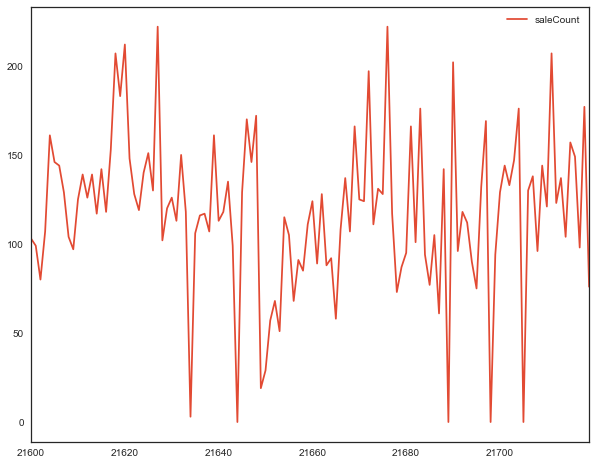

In [3]:
train_12.plot()

In [45]:
def exclude_abnormal_value(train):
    coord  = train.groupby('Class',as_index=False)['saleCount'].agg({'saleCount_mean':'mean'})
    train = pd.merge(train, coord, on='Class', how = 'left')
    coord  = train.groupby('Class',as_index=False)['saleCount'].agg({'saleCount_std':'std'})
    train = pd.merge(train, coord, on='Class', how = 'left')
    train.loc[:,'saleCount_min'] = train['saleCount_mean'] - 2 * train['saleCount_std']
    train.loc[:,'saleCount_max'] = train['saleCount_mean'] + 2 * train['saleCount_std']
    train['saleCount_max'] = np.ceil(train['saleCount_max'])
    max_bool = train['saleCount_max'] < train['saleCount']
    train['saleCount'][max_bool] = train['saleCount_max'][max_bool]
    neg_bool = train['saleCount_min'] < 0
    train['saleCount_min'][neg_bool] = 0
    min_bool = train['saleCount_min'] > train['saleCount']
    train['saleCount'][min_bool] = train['saleCount_min'][min_bool]
    train['saleCount'] = np.ceil(train['saleCount'])
    del train['saleCount_min'],train['saleCount_max'],train['saleCount_std'],train['saleCount_mean']
    return train

In [44]:
ts = train_12.copy()
ts.loc[:,'count'] = range(ts.shape[0])
ts['count'] = (ts['count'] / 7).astype('int')
coord = ts.groupby('count',as_index=False)['saleCount'].agg({'mean':'mean'})
ts = pd.merge(ts, coord, on='count',how='left')
coord = ts.groupby('count',as_index=False)['saleCount'].agg({'std':'std'})
ts = pd.merge(ts, coord, on='count',how='left')
ts['mean'] = ts['mean'].shift(7)
ts['std'] = ts['std'].shift(7)
ts['mean'][ts['count'] == 0] = ts['saleCount'][ts['count'] == 0].mean()
ts['std'][ts['count'] == 0] = ts['saleCount'][ts['count'] == 0].std()
ts

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SaleDate,saleCount,count,mean,std
0,2015-01-01,103,0,120.000000,30.088758
1,2015-01-02,99,0,120.000000,30.088758
2,2015-01-03,80,0,120.000000,30.088758
3,2015-01-04,107,0,120.000000,30.088758
4,2015-01-05,161,0,120.000000,30.088758
5,2015-01-06,146,0,120.000000,30.088758
6,2015-01-07,144,0,120.000000,30.088758
7,2015-01-08,129,1,120.000000,30.088758
8,2015-01-09,104,1,120.000000,30.088758
9,2015-01-10,97,1,120.000000,30.088758


In [48]:
ts.loc[:,'saleCount_min'] = ts['mean'] - 2 * ts['std']
ts.loc[:,'saleCount_max'] = ts['mean'] + 2 * ts['std']
ts['saleCount_max'] = np.ceil(ts['saleCount_max'])
max_bool = ts['saleCount_max'] < ts['saleCount']
ts['saleCount'][max_bool] = ts['saleCount_max'][max_bool]
neg_bool = ts['saleCount_min'] < 0
ts['saleCount_min'][neg_bool] = 0
min_bool = ts['saleCount_min'] > ts['saleCount']
ts['saleCount'][min_bool] = ts['saleCount_min'][min_bool]
ts['saleCount'] = np.ceil(ts['saleCount'])
ts

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SaleDate,saleCount,count,mean,std,saleCount_min,saleCount_max
0,2015-01-01,103.0,0,120.000000,30.088758,59.822485,181.0
1,2015-01-02,99.0,0,120.000000,30.088758,59.822485,181.0
2,2015-01-03,80.0,0,120.000000,30.088758,59.822485,181.0
3,2015-01-04,107.0,0,120.000000,30.088758,59.822485,181.0
4,2015-01-05,161.0,0,120.000000,30.088758,59.822485,181.0
5,2015-01-06,146.0,0,120.000000,30.088758,59.822485,181.0
6,2015-01-07,144.0,0,120.000000,30.088758,59.822485,181.0
7,2015-01-08,129.0,1,120.000000,30.088758,59.822485,181.0
8,2015-01-09,104.0,1,120.000000,30.088758,59.822485,181.0
9,2015-01-10,97.0,1,120.000000,30.088758,59.822485,181.0


In [49]:
tmp = ts[['SaleDate','saleCount']]

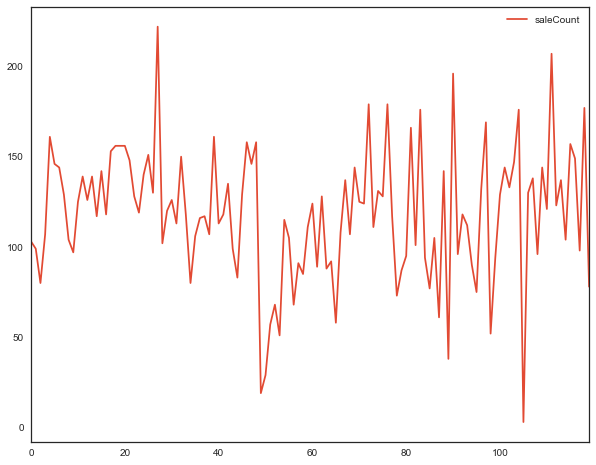

In [50]:
tmp.plot()

C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda2\lib\site-pac

bic: 174.147518532 p: 0 q: 4
[-0.02708021]
forcast -0.0270802112822


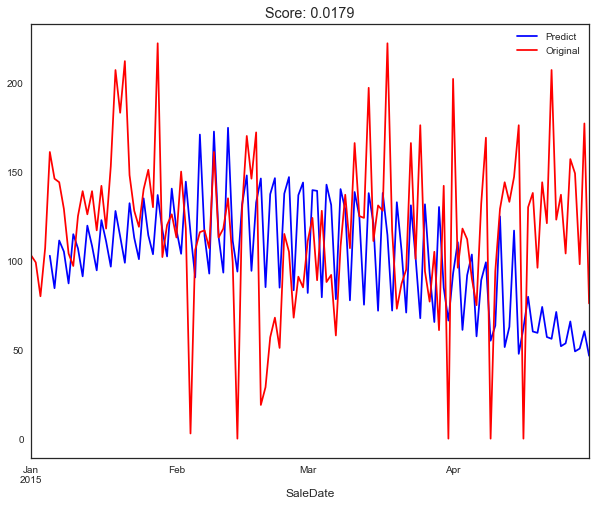

In [102]:
# -*-coding:utf-8-*-
import pandas as pd
import numpy as np
from arima_model import ARMA
import sys
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import matplotlib.pyplot as plt

class arima_model:

    def __init__(self, ts, maxLag=9):
        self.data_ts = ts
        self.resid_ts = None
        self.predict_ts = None
        self.maxLag = maxLag
        self.p = maxLag
        self.q = maxLag
        self.properModel = None
        self.bic = sys.maxint

    # 计算最优ARIMA模型，将相关结果赋给相应属性
    def get_proper_model(self):
        self._proper_model()
        self.predict_ts = deepcopy(self.properModel.predict())
        self.resid_ts = deepcopy(self.properModel.resid)

    # 对于给定范围内的p,q计算拟合得最好的arima模型，这里是对差分好的数据进行拟合，故差分恒为0
    def _proper_model(self):
        for p in np.arange(self.maxLag):
            for q in np.arange(self.maxLag):
                # print p,q,self.bic
                model = ARMA(self.data_ts, order=(p, q))
                try:
                    results_ARMA = model.fit(disp=-1, method='css')
                except:
                    continue
                bic = results_ARMA.bic
                # print 'bic:',bic,'self.bic:',self.bic
                if bic < self.bic:
                    self.p = p
                    self.q = q
                    self.properModel = results_ARMA
                    self.bic = bic
                    self.resid_ts = deepcopy(self.properModel.resid)
                    self.predict_ts = self.properModel.predict()

    # 参数确定模型
    def certain_model(self, p, q):
            model = ARMA(self.data_ts, order=(p, q))
            try:
                self.properModel = model.fit( disp=-1, method='css')
                self.p = p
                self.q = q
                self.bic = self.properModel.bic
                self.predict_ts = self.properModel.predict()
                self.resid_ts = deepcopy(self.properModel.resid)
            except:
                print 'You can not fit the model with this parameter p,q, ' \
                      'please use the get_proper_model method to get the best model'

    # 预测第二日的值
    def forecast_next_day_value(self, type='day'):
        # 我修改了statsmodels包中arima_model的源代码，添加了constant属性，需要先运行forecast方法，为constant赋值
        self.properModel.forecast()
        if self.data_ts.index[-1] != self.resid_ts.index[-1]:
            raise ValueError('''The index is different in data_ts and resid_ts, please add new data to data_ts.
            If you just want to forecast the next day data without add the real next day data to data_ts,
            please run the predict method which arima_model included itself''')
        if not self.properModel:
            raise ValueError('The arima model have not computed, please run the proper_model method before')
        para = self.properModel.params

        # print self.properModel.params
        if self.p == 0:   # It will get all the value series with setting self.data_ts[-self.p:] when p is zero
            ma_value = self.resid_ts[-self.q:]
            values = ma_value.reindex(index=ma_value.index[::-1])
        elif self.q == 0:
            ar_value = self.data_ts[-self.p:]
            values = ar_value.reindex(index=ar_value.index[::-1])
        else:
            ar_value = self.data_ts[-self.p:]
            ar_value = ar_value.reindex(index=ar_value.index[::-1])
            ma_value = self.resid_ts[-self.q:]
            ma_value = ma_value.reindex(index=ma_value.index[::-1])
            values = ar_value.append(ma_value)

        predict_value = np.dot(para[1:], values) + self.properModel.constant[0]
        self._add_new_data(self.predict_ts, predict_value, type)
        return predict_value

    # 动态添加数据函数，针对索引是月份和日分别进行处理
    def _add_new_data(self, ts, dat, type='day'):
        if type == 'day':
            new_index = ts.index[-1] + relativedelta(days=1)
        elif type == 'month':
            new_index = ts.index[-1] + relativedelta(months=1)
        ts[new_index] = dat

    def add_today_data(self, dat, type='day'):
        self._add_new_data(self.data_ts, dat, type)
        if self.data_ts.index[-1] != self.predict_ts.index[-1]:
            raise ValueError('You must use the forecast_next_day_value method forecast the value of today before')
        self._add_new_data(self.resid_ts, self.data_ts[-1] - self.predict_ts[-1], type)
        
from sklearn.metrics import mean_squared_error
def score(y_test,y_pred):
    return 1.0 / (1.0 + np.sqrt(mean_squared_error(y_test, y_pred)))

if __name__ == '__main__':
    data = train_12.copy()
    tmp = train_12.copy()
    data.to_csv('train_12.csv',index=False)
    data = pd.read_csv('train_12.csv',index_col=['SaleDate'])
    data['saleCount'][data['saleCount'] == 0] = 0.1
    data.index = pd.to_datetime(data.index)
    ts_origin = data['saleCount']  # 生成pd.Series对象
#     ts_origin = ts_origin['2015-02-01':]
#     ts_log = np.log(ts)
    
    data = tmp.copy()
    data.to_csv('train_12_f.csv',index=False)
    data = pd.read_csv('train_12_f.csv',index_col=['SaleDate'])
    data['saleCount'][data['saleCount'] == 0] = 0.1
    data.index = pd.to_datetime(data.index)
    ts = data['saleCount']  # 生成pd.Series对象
#     ts = ts['2015-02-01':]        

    ts_log = np.log(ts)

    # 数据预处理
    step = 3
    ts_log = np.log(ts)
    rol_mean = ts_log.rolling(window=step).mean()
    rol_mean.dropna(inplace=True)
    ts_diff_1 = rol_mean.diff(1)
    ts_diff_1.dropna(inplace=True)
    ts_diff_2 = ts_diff_1.diff(1)
    ts_diff_2.dropna(inplace=True)

    # 模型拟合
    model = arima_model(ts_diff_2)
    #  这里使用模型参数自动识别
    model.get_proper_model()
    print 'bic:', model.bic, 'p:', model.p, 'q:', model.q
    print model.properModel.forecast()[0]
    print "forcast",model.forecast_next_day_value(type='day')

    # 预测结果还原
    predict_ts = model.properModel.predict()
    diff_shift_ts = ts_diff_1.shift(1)
    diff_recover_1 = predict_ts.add(diff_shift_ts)
    rol_shift_ts = rol_mean.shift(1)
    diff_recover = diff_recover_1.add(rol_shift_ts)
    rol_sum = ts_log.rolling(window=step-1).sum()
    rol_recover = diff_recover*step - rol_sum.shift(1)
    log_recover = np.exp(rol_recover)
    log_recover.dropna(inplace=True)

    # 预测结果作图
    ts_origin = ts_origin[log_recover.index]
    plt.figure(facecolor='white')
    log_recover.plot(color='blue', label='Predict')
    ts.plot(color='red', label='Original')
    plt.legend(loc='best')
    plt.title('Score: %.4f'% score(log_recover,ts_origin))

    plt.show()

In [93]:
data = train_12.copy()
tmp = train_12.copy()
data.to_csv('train_12.csv',index=False)
data = pd.read_csv('train_12.csv',index_col=['SaleDate'])
data['saleCount'][data['saleCount'] == 0] = 0.1
data.index = pd.to_datetime(data.index)
ts_origin = data['saleCount']  # 生成pd.Series对象

In [95]:
ts_train = ts_origin[:'2015-03-31']
ts_test = ts_origin['2015-04-01':]

In [98]:
ts_train.rolling(2).mean()

SaleDate
2015-01-01       NaN
2015-01-02    101.00
2015-01-03     89.50
2015-01-04     93.50
2015-01-05    134.00
2015-01-06    153.50
2015-01-07    145.00
2015-01-08    136.50
2015-01-09    116.50
2015-01-10    100.50
2015-01-11    111.00
2015-01-12    132.00
2015-01-13    132.50
2015-01-14    132.50
2015-01-15    128.00
2015-01-16    129.50
2015-01-17    130.00
2015-01-18    135.50
2015-01-19    180.00
2015-01-20    195.00
2015-01-21    197.50
2015-01-22    180.00
2015-01-23    138.00
2015-01-24    123.50
2015-01-25    129.50
2015-01-26    145.50
2015-01-27    140.50
2015-01-28    176.00
2015-01-29    162.00
2015-01-30    111.00
               ...  
2015-03-02    117.50
2015-03-03    106.50
2015-03-04    108.50
2015-03-05    108.00
2015-03-06     90.00
2015-03-07     75.00
2015-03-08     83.00
2015-03-09    122.50
2015-03-10    122.00
2015-03-11    136.50
2015-03-12    145.50
2015-03-13    124.50
2015-03-14    160.50
2015-03-15    154.00
2015-03-16    121.00
2015-03-17    129.50
2015